# Unsupervised image denoising

## Import libraries

In [53]:
import torch
import torchvision
from torch.utils.data import Dataset
from os import listdir
from os.path import join
from torchvision.transforms import Compose, ToTensor, ToPILImage, Resize, Lambda, Normalize, Grayscale
from torch.utils.data import DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from skimage.feature import hog
from math import log10
from sklearn import svm
from tqdm.notebook import tqdm
import os
import matplotlib.image as img
import matplotlib.pyplot as plt
import matplotlib.colors as colors

## Load data

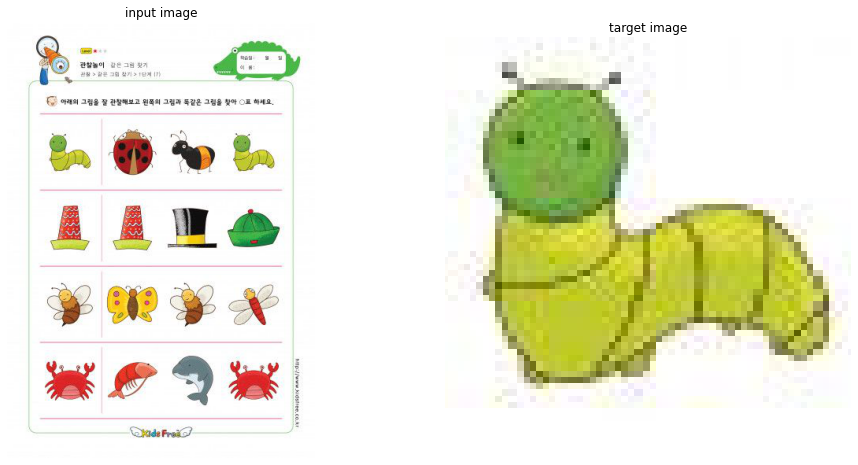

In [54]:
directory_data  = './'
image_train_data   = 'image_train2.jpg'
image_target_data   = 'image_target2.png'
image_train      = img.imread(os.path.join(directory_data, image_train_data))
image_target    = img.imread(os.path.join(directory_data,image_target_data))


plt.figure(figsize=(16,8))
plt.subplot(121)
plt.imshow(image_train, cmap = 'gray')
plt.title('input image')
plt.axis('off')
plt.subplot(122)
plt.imshow(image_target, cmap = 'gray')
plt.title('target image')
plt.axis('off')

num_train   = image_train.shape
num_target  = image_target.shape

In [55]:
def gray_scale(image):
  if len(image.shape) == 3:
    image = image.mean(2)
  image = (image - image.min())/(image.max() - image.min())
  return image

Normalize input image so that the range of image is [0,1]

In [56]:
print('*************************************************')
print('size of train :', image_train.shape)
print('*************************************************')
print('size of target :', image_target.shape)

*************************************************
size of train : (553, 391, 3)
*************************************************
size of target : (129, 129, 4)


In [57]:
fd, hog_image_train = hog(gray_scale(image_train),orientations= 9 ,pixels_per_cell=(8,8), cells_per_block=(2,2),visualize=True)
hog_image_target = hog(gray_scale(image_target),orientations= 9 ,pixels_per_cell=(8,8), cells_per_block=(2,2) ,feature_vector=True)
image_train_gray = (hog_image_train)
image_tartget_gray = (hog_image_target)
print('*************************************************')
print('size of train :', image_train_gray.shape )
print('*************************************************')
print('size of target :', image_tartget_gray.shape)

# plt.figure(figsize=(16,8))
# plt.subplot(121)
# plt.imshow(image_train_gray, cmap = 'gray')
# plt.title('input image')
# plt.axis('off')
# plt.subplot(122)
# plt.imshow(image_tartget_gray, cmap = 'gray')
# plt.title('target image')
# plt.axis('off')

*************************************************
size of train : (553, 391)
*************************************************
size of target : (8100,)


In [58]:
def conv(image, window, stride=1, pad=0):
  h, w = image.shape

  window_h, window_w = window.shape

  window_std = window.std()
  window_mean = window.mean()
  out_h = int((h+2*pad-window_h)/stride +1)
  out_w = int((w+2*pad-window_w)/stride +1)
  input = torch.nn.functional.pad(input=image, pad=(pad,pad,pad,pad), mode='constant', value = 0)
  # add padding to height and width. 
  #  # padding으로 모양이 커진 in_X
  # print(n, n_f, out_h, out_w)
  out = torch.zeros((out_h, out_w))
  for h in range(out_h):
    h_start = h*stride # 시작지점에 stride 적용
    h_end = h_start + window_h 
    for w in range(out_w):
      w_start  = w*stride # 시작지점에 stride 적용
      w_end = w_start + window_w
      target = input[h_start:h_end, w_start:w_end]
      target_std = target.std()
      target_mean = target.mean()
      out[h, w] = ((target - target_mean) *(window-window_mean)).mean()/(target_std*window_std)
  return out

## Cross Correlation을 이용한 output

In [59]:

# def convolution(image, filter):
#   out = conv(image = image,window = filter,stride = 1, pad = 64)
#   return out
# out = convolution(image_train_gray, image_tartget_gray)
# ret = out.argmax(dim = 1,keepdim= True)
# plt.matshow(out,cmap = 'red')

In [62]:
fd, hog_image_train = hog(gray_scale(image_train),orientations= 9 ,pixels_per_cell=(8,8), cells_per_block=(2,2),visualize=True)
hog_image_target = hog(gray_scale(image_target),orientations= 9 ,pixels_per_cell=(8,8), cells_per_block=(2,2) ,feature_vector=True)
image_train_gray = (hog_image_train)
image_tartget_gray = (hog_image_target)
print('*************************************************')
print('size of train :', image_train_gray.shape )
print('*************************************************')
print('size of target :', image_tartget_gray.shape)
clf = svm.LinearSVR()
clf.fit(hog_image_train, hog_image_target)


*************************************************
size of train : (553, 391)
*************************************************
size of target : (8100,)


ValueError: Found input variables with inconsistent numbers of samples: [553, 8100]

In [ ]:
num_col = image_train.shape[1]
print(out.max())
ret = out.argmax()

x =  ret % num_col 
y = ret / num_col
print(ret/num_col)
print(ret%num_col)

tensor(0.4397)
tensor(147)
tensor(187)


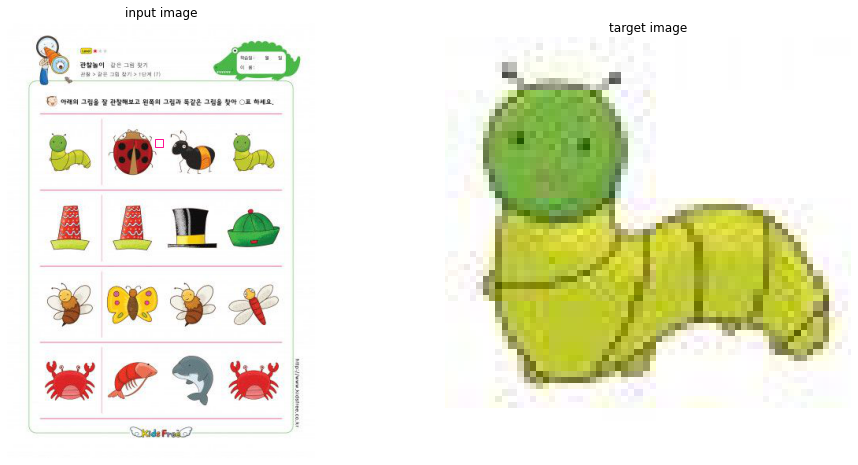

In [ ]:
import matplotlib.patches as patches

plt.figure(figsize=(16,8))
plt.subplot(121)
plt.imshow(image_train, cmap = 'gray')
plt.gca().add_patch(patches.Rectangle((x ,y),width = 10,height = 10,edgecolor = 'deeppink',facecolor='lightgray',fill = False,))
plt.title('input image')
plt.axis('off')
plt.subplot(122)
plt.imshow(image_target, cmap = 'gray')
plt.title('target image')
plt.axis('off')

plt.show()